[Local](./ch07.ipynb),
[Github](https://github.com/renyuanL/_ryDsp2020/blob/master/code/ch07.ipynb),
[Colab](https://colab.research.google.com/github/renyuanL/_ryDsp2020/blob/master/code/ch07.ipynb)

[TextBook@greenteapress](http://greenteapress.com/thinkdsp/html/thinkdsp008.html)

# Chapter 7  Discrete Fourier Transform

We’ve been using the discrete Fourier transform (DFT) since Chapter 1, but I haven’t explained how it works. Now is the time.

If you understand the discrete cosine transform (DCT), you will understand the DFT. The only difference is that instead of using the `cosine` function, we’ll use the `complex exponential` function. I’ll start by explaining complex exponentials, then I’ll follow the same progression as in Chapter 6:

- We’ll start with the synthesis problem: given a set of frequency components and their amplitudes, how can we construct a signal? The synthesis problem is equivalent to the inverse DFT.
- Then I’ll rewrite the synthesis problem in the form of matrix multiplication using NumPy arrays.
- Next we’ll solve the analysis problem, which is equivalent to the DFT: given a signal, how do we find the amplitude and phase offset of its frequency components?
- Finally, we’ll use linear algebra to find a more efficient way to compute the DFT.

The code for this chapter is in `chap07.ipynb`, which is in the repository for this book (see Section 0.2). You can also view it at http://tinyurl.com/thinkdsp07.

## 7.1  Complex exponentials

One of the more interesting moves in mathematics is the generalization of an operation from one type to another. For example, `factorial` ($n!$) is a function that operates on integers; the natural definition for factorial of n is the product of all integers from 1 to n.

$
n! = n (n-1) (n-2) \cdots (2) (1)
$

If you are of a certain inclination, you might wonder how to compute the factorial of a non-integer like 3.5. Since the natural definition doesn’t apply, you might look for other ways to compute the factorial function, ways that would work with non-integers.

$
4! = (4)(3)(2)(1) = 24
\\
3! = (3)(2)(1) = 6
\\
(3.5) ! = ?
$

In 1730, Leonhard Euler found one, a `generalization` of the factorial function that we know as the `Gamma function` (see http://en.wikipedia.org/wiki/Gamma_function).

For any positive integer $n$,

$
{\displaystyle \Gamma (n)=(n-1)!\ .}
$

$
{\displaystyle \Gamma (z)=\int _{0}^{\infty }x^{z-1}e^{-x}\,dx,\ \qquad \Re (z)>0\ .}
$


![](https://upload.wikimedia.org/wikipedia/commons/thumb/5/52/Gamma_plot.svg/1280px-Gamma_plot.svg.png)

Euler also found one of the most useful generalizations in applied mathematics, the `complex exponential function`.

The natural definition of `exponentiation` is `repeated multiplication`. 

For example,

$φ^3 = φ · φ · φ$ 

But this definition doesn’t apply to non-integer exponents.

However, exponentiation can also be expressed as a power series:

$
e^φ= 1 + φ + φ^2/2! + φ^3/3! + ... 
$

This definition works with real numbers, imaginary numbers and, by a simple extension, with complex numbers. 

Applying this definition to a pure imaginary number, $iφ$, we get

$
e^{iφ} = 1 + iφ − φ^2/2! − iφ^3/3! + ... 
$

By rearranging terms, we can show that this is equivalent to:

$
e^{iφ} = cos(φ) + i \cdot sin(φ) 
$

You can see the derivation at http://en.wikipedia.org/wiki/Euler's_formula.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Euler%27s_formula.svg/1280px-Euler%27s_formula.svg.png)

This formula implies that $e^{iφ}$ is a complex number with magnitude 1; if you think of it as a point in the complex plane, it is always on the `unit circle`. And if you think of it as a vector, the angle in radians between the vector and the positive x-axis is the argument, $φ$.

In the case where the exponent is a complex number, we have:

$
e^{a + iφ} = e^a e^{iφ} = A \cdot e^{iφ} 
$

where A is a real number that indicates amplitude and $e^{iφ}$ is a unit complex number that indicates angle.

NumPy provides a version of exp that works with complex numbers:

```python
>>> φ = 1.5
>>> z = np.exp(1j * φ)
>>> z
(0.0707+0.997j)
```

In [11]:
z1= (1+1j)
z2= 2-3j
z1+z2, z1*z2, z1**2, z1**(.5)

import numpy as np

np.exp(2+3j)
np.angle(1+1j)*180/np.pi 

45.0

Python uses `j` to represent the imaginary unit, rather than `i`. 

A `number ending in j` is considered imaginary, so `1j` is just `i`.

When the argument to np.exp is imaginary or complex, the result is a complex number; specifically, a np.complex128, which is represented by two 64-bit floating-point numbers. In this example, the result is `0.0707+0.997j`.

Complex numbers have attributes real and imag:

```python
>>> z.real
0.0707
>>> z.imag
0.997
```

To get the magnitude, you can use the built-in function abs or np.absolute:

```python
>>> abs(z)
1.0
>>> np.absolute(z)
1.0
```

To get the angle, you can use np.angle:

```python
>>> np.angle(z)
1.5
```

This example confirms that $e^{iφ}$ is a complex number with magnitude 1 and angle φ radians.

## 7.2  Complex signals

If φ(t) is a function of time, $e^{i φ(t)}$ is also a function of time. Specifically,

$e^{i φ(t)} = cos (φ(t)) + i \cdot sin(φ(t)) $

This function describes a quantity that varies in time, so it is a signal. Specifically, it is a `complex exponential signal`.

In the special case where the frequency of the signal is constant, 

$φ(t) = 2 π f t $

and the result is a complex sinusoid:

$
e^{i 2 π f t} = cos (2 π f t) + i \cdot sin(2 π f t) 
$

Or more generally, the signal might start at a phase offset $φ_0$, yielding

$
e^{i (2 π f t + φ_0)} 
$

thinkdsp provides an implementation of this signal, `ComplexSinusoid`

```python 
class ComplexSinusoid(Sinusoid):

   def evaluate(self, ts):
        phases = PI2 * self.freq * ts + self.offset
        ys = self.amp * np.exp(1j * phases)
        return ys
```

`class ComplexSinusoid` inherits `__init__` from `class Sinusoid`. 

It provides a version of `evaluate` that is almost identical to `Sinusoid.evaluate`; the only difference is that it uses `np.exp ` instead of `np.sin`.

The result is a NumPy array of complex numbers:


```python 
>>> signal = thinkdsp.ComplexSinusoid(freq=1, amp=0.6, offset=1)
>>> wave = signal.make_wave(duration=1, framerate=4)
>>> wave.ys
[ 0.324+0.505j -0.505+0.324j -0.324-0.505j  0.505-0.324j]
```

The frequency of this signal is 1 cycle per second; the amplitude is 0.6 (in unspecified units); and the phase offset is 1 radian.

This example evaluates the signal at 4 places equally spaced between 0 and 1 second. The resulting samples are complex numbers.

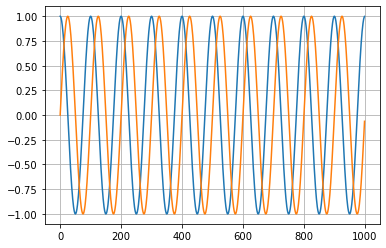

In [38]:
import thinkdsp as td
s= td.ComplexSinusoid(freq= 1)
w= s.make_wave(duration=10, framerate=100)
w.ys.size, 
w.ys #  it is a complex signal
import matplotlib.pyplot as pl
pl.plot(w.ys.real); pl.grid(True)
pl.plot(w.ys.imag); pl.grid(True)

In [ ]:
pl.plot(w.ys) # this will show only the real-part 
pl.grid(True)

pl.plot(abs(w.ys))

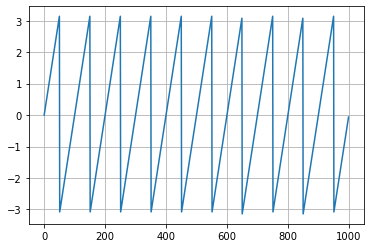

In [40]:
pl.plot(np.angle(w.ys)); pl.grid(True)

## 7.3  The synthesis problem

Just as we did with real sinusoids, we can create compound signals by adding up complex sinusoids with different frequencies. And that brings us to the complex version of the synthesis problem: given the frequency and amplitude of each complex component, how do we evaluate the signal?

The simplest solution is to create ComplexSinusoid objects and add them up.

```python
def synthesize1(amps, fs, ts):
    components = [thinkdsp.ComplexSinusoid(freq, amp)
                  for amp, freq in zip(amps, fs)]
    signal = thinkdsp.SumSignal(*components)
    ys = signal.evaluate(ts)
    return ys
```

This function is almost identical to synthesize1 in Section 6.1; the only difference is that I replaced `CosSignal` with `ComplexSinusoid`.

Here’s an example:

```python
    amps = np.array([0.6, 0.25, 0.1, 0.05])
    fs = [100, 200, 300, 400]
    framerate = 11025
    ts = np.linspace(0, 1, framerate)
    ys = synthesize1(amps, fs, ts)
```
    
The result is:

```python
[ 1.000 +0.000e+00j  0.995 +9.093e-02j  0.979 +1.803e-01j ...,
  0.979 -1.803e-01j  0.995 -9.093e-02j  1.000 -5.081e-15j]
```

At the lowest level, a complex signal is a sequence of complex numbers. But how should we interpret it? We have some intuition for real signals: they represent quantities that vary in time; for example, a sound signal represents changes in air pressure. But nothing we measure in the world yields complex numbers.

![](http://greenteapress.com/thinkdsp/html/thinkdsp037.png)
Figure 7.1: Real and imaginary parts of a mixture of complex sinusoids.

So what is a complex signal? I don’t have a satisfying answer to this question. The best I can offer is two unsatisfying answers:

A complex signal is a mathematical abstraction that is useful for computation and analysis, but it does not correspond directly with anything in the real world.

If you like, you can think of a complex signal as a sequence of complex numbers that contains two signals as its real and imaginary parts.

Taking the second point of view, we can split the previous signal into its real and imaginary parts:

```python
    n = 500
    plt.plot(ts[:n], ys[:n].real, label='real')
    plt.plot(ts[:n], ys[:n].imag, label='imag')
```

Figure 7.1 shows a segment of the result. The real part is a sum of cosines; the imaginary part is a sum of sines. Although the waveforms look different, they contain the same frequency components in the same proportions. To our ears, they sound the same (in general, we don’t hear phase offsets).

## 7.4  Synthesis with matrices

As we saw in Section 6.2, we can also express the synthesis problem in terms of matrix multiplication:

```python
PI2 = np.pi * 2

def synthesize2(amps, fs, ts):
    args = np.outer(ts, fs)
    M = np.exp(1j * PI2 * args)
    ys = np.dot(M, amps)
    return ys
```

Again, 

- amps is a NumPy array that contains a sequence of amplitudes.
- fs is a sequence containing the frequencies of the components. 
- ts contains the times where we will evaluate the signal.
- args contains the outer product of ts and fs, with the ts running down the rows and the fs running across the columns (you might want to refer back to Figure 6.1).

Each column of matrix M contains a complex sinusoid with a particular frequency, evaluated at a sequence of ts.

When we multiply M by the amplitudes, the result is a vector whose elements correspond to the ts; each element is the sum of several complex sinusoids, evaluated at a particular time.

Here’s the example from the previous section again:

```python
>>> ys = synthesize2(amps, fs, ts)
>>> ys
[ 1.000 +0.000e+00j  0.995 +9.093e-02j  0.979 +1.803e-01j ...,
  0.979 -1.803e-01j  0.995 -9.093e-02j  1.000 -5.081e-15j]
```

The result is the same.

In this example the amplitudes are real, but they could also be complex. What effect does a complex amplitude have on the result? Remember that we can think of a complex number in two ways: either the sum of a real and imaginary part, x + i y, or the product of a real amplitude and a complex exponential, A ei φ0. Using the second interpretation, we can see what happens when we multiply a complex amplitude by a complex sinusoid. For each frequency, f, we have:

$
A e^{i φ_0} · e^{i 2 π f t} = A e^{i (2 π f t + φ_0)} 
$

Multiplying by $A e^{i φ_0}$ multiplies the amplitude by $A$ and adds the phase offset $φ_0$.


![](http://greenteapress.com/thinkdsp/html/thinkdsp038.png)
Figure 7.2: Real part of two complex signals that differ by a phase offset.

We can test that claim by running the previous example with $φ_0 = 1.5$ for all frequency components:

```python
    φ = 1.5
    amps2 = amps * np.exp(1j * φ)
    ys2 = synthesize2(amps2, fs, ts)

    plt.plot(ts[:n], ys.real[:n])
    plt.plot(ts[:n], ys2.real[:n])
```

Since amps is an array of reals, multiplying by `np.exp(1j * φ)` yields an array of complex numbers with phase offset φ radians, and the same magnitudes as amps.

Figure 7.2 shows the result. The phase offset $φ_0 = 1.5$ shifts the wave to the left by about one quarter of a cycle; it also changes the waveform, because the same phase offset applied to different frequencies changes how the frequency components line up with each other.

Now that we have the more general solution to the synthesis problem – one that handles complex amplitudes – we are ready for the analysis problem.

## 7.5  The analysis problem

The analysis problem is the inverse of the synthesis problem: given a sequence of samples, y, and knowing the frequencies that make up the signal, can we compute the complex amplitudes of the components, a?

As we saw in Section 6.3, we can solve this problem by forming the synthesis matrix, M, and solving the system of linear equations, M a = y for a.

```python
def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.exp(1j * PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps
```

`analyze1` takes 
- a (possibly complex) wave array, `ys`, 
- a sequence of real frequencies, `fs`, 
- and a sequence of real times, `ts`. 

It returns a sequence of complex amplitudes, `amps`.

Continuing the previous example, we can confirm that analyze1 recovers the amplitudes we started with. For the linear system solver to work, M has to be square, so we need ys, fs and ts to have the same length. I’ll insure that by slicing ys and ts down to the length of fs:

```python
>>> n = len(fs)
>>> amps2 = analyze1(ys[:n], fs, ts[:n])
>>> amps2
[ 0.60+0.j  0.25-0.j  0.10+0.j  0.05-0.j]
```

These are approximately the amplitudes we started with, although each component has a small imaginary part due to floating-point errors.

## 7.6  Efficient analysis

Unfortunately, solving a linear system of equations is slow. For the DCT, we were able to speed things up by choosing fs and ts so that M is orthogonal. That way, the inverse of M is the transpose of M, and we can compute both DCT and inverse DCT by matrix multiplication.

We’ll do the same thing for the DFT, with one small change. Since M is complex, we need it to be unitary, rather than orthogonal, which means that the inverse of M is the conjugate transpose of M, which we can compute by transposing the matrix and negating the imaginary part of each element. See http://en.wikipedia.org/wiki/Unitary_matrix.

The NumPy methods conj and transpose do what we want. Here’s the code that computes M for N=4 components:

```python
    N = 4
    ts = np.arange(N) / N
    fs = np.arange(N)
    args = np.outer(ts, fs)
    M = np.exp(1j * PI2 * args)
```

If M is unitary, $M^{*} M = I$, where $M^{*}$ is the conjugate transpose of $M$, and I is the identity matrix. 
We can test whether $M$ is `unitary` like this:

    MstarM = M.conj().transpose().dot(M)
    
The result, within the tolerance of floating-point error, is $4 I$, so $M$ is `unitary` except for an extra factor of $N$, similar to the extra factor of 2 we found with the DCT.

We can use this result to write a faster version of `analyze1`:

```python
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.exp(1j * PI2 * args)
    amps = M.conj().transpose().dot(ys) / N
    return amps
```
And test it with appropriate values of fs and ts:

```python
    N = 4
    amps = np.array([0.6, 0.25, 0.1, 0.05])
    fs = np.arange(N)
    ts = np.arange(N) / N
    ys = synthesize2(amps, fs, ts)
    amps3 = analyze2(ys, fs, ts)
```

Again, the result is correct within the tolerance of floating-point arithmetic.

```python
[ 0.60+0.j  0.25+0.j  0.10-0.j  0.05-0.j]
```

## 7.7  DFT

As a function, `analyze2` would be hard to use because it only works if `fs` and `ts` are chosen correctly. 

Instead, I will rewrite it to take just `ys` and compute freq and ts itself.

First, I’ll make a function to compute the synthesis matrix, M:

```python
def synthesis_matrix(N):
    ts = np.arange(N) / N
    fs = np.arange(N)
    args = np.outer(ts, fs)
    M = np.exp(1j * PI2 * args)
    return M
```

Then I’ll write the function that takes ys and returns amps:

```python
def analyze3(ys):
    N = len(ys)
    M = synthesis_matrix(N)
    amps = M.conj().transpose().dot(ys) / N
    return amps
```

We are almost done; `analyze3` computes something very close to the DFT, with one difference. The conventional definition of DFT does not divide by N:

```python
def dft(ys):
    N = len(ys)
    M = synthesis_matrix(N)
    amps = M.conj().transpose().dot(ys)
    return amps
```

Now we can confirm that my version yields the same result as FFT:

```python
>>> dft(ys)
[ 2.4+0.j  1.0+0.j  0.4-0.j  0.2-0.j]
```

The result is close to amps * N. And here’s the version in np.fft:

```python
>>> np.fft.fft(ys)
[ 2.4+0.j  1.0+0.j  0.4-0.j  0.2-0.j]
```

They are the same, within floating point error.

The inverse DFT is almost the same, except we don’t have to transpose and conjugate M, and now we have to divide through by N:

```python
def idft(ys):
    N = len(ys)
    M = synthesis_matrix(N)
    amps = M.dot(ys) / N
    return amps
```    

Finally, we can confirm that dft(idft(amps)) yields amps.

```python
>>> ys = idft(amps)
>>> dft(ys)
[ 0.60+0.j  0.25+0.j  0.10-0.j  0.05-0.j]
```

If I could go back in time, I might change the definition of DFT so it divides by N and the inverse DFT doesn’t. That would be more consistent with my presentation of the synthesis and analysis problems.

Or I might change the definition so that both operations divide through by $\sqrt{N}$. Then the DFT and inverse DFT would be more symmetric.

But I can’t go back in time (yet!), so we’re stuck with a slightly weird convention. For practical purposes it doesn’t really matter.

## 7.8  The DFT is periodic

In this chapter I presented the DFT in the form of matrix multiplication. We compute the synthesis matrix, $M$, and the analysis matrix, $M^{*}$. When we multiply $M^{*}$ by the wave array, $y$, each element of the result is the product of a row from $M^{*}$ and y, which we can write in the form of a summation:

$
DFT(y)[k] = 
\sum_{n=0}^{N-1} 
y[n] \cdot e^{−i (2 π/N) n k } 
$

where k is an index of frequency from 0 to N−1 and n is an index of time from 0 to N−1. 

So $DFT(y)[k]$ is the $k^{th}$ element of the DFT of y.

Normally we evaluate this summation for N values of k, running from 0 to N−1. We could evaluate it for other values of k, but there is no point, because they start to repeat. That is, the value at $k$ is the same as the value at $k+N$ or $k+2N$ or $k−N$, etc.

We can see that mathematically by plugging $k+N$ into the summation:

$
DFT(y)[k+N] = 
\sum_{n=0}^{N-1} 
y[n] \cdot e^{−i (2 π/N) n (k+N) } 
$

by the way, it can be shown that

$
DFT(y)[k+N] === DFT(y)[k]  
$

So the DFT is periodic, with period $N$. 

You will need this result for one of the exercises below, which asks you to implement the Fast Fourier Transform (FFT).

As an aside, writing the DFT in the form of a summation provides an insight into how it works. If you review the diagram in Section 6.2, you’ll see that each column of the synthesis matrix is a signal evaluated at a sequence of times. The analysis matrix is the (conjugate) transpose of the synthesis matrix, so each row is a signal evaluated at a sequence of times.

Therefore, each summation is the correlation of y with one of the signals in the array (see Section 5.5). That is, each element of the DFT is a correlation that quantifies the similarity of the wave array, y, and a complex exponential at a particular frequency.

## 7.9  DFT of real signals

![](http://greenteapress.com/thinkdsp/html/thinkdsp039.png)

Figure 7.3: DFT of a 500 Hz sawtooth signal sampled at 10 kHz.

The `class Spectrum` in thinkdsp is based on `np.ftt.rfft`, which computes the “real DFT”; that is, it works with real signals. 

But the DFT as presented in this chapter is more general than that; it works with complex signals.

So what happens when we apply the “full DFT” to a real signal? Let’s look at an example:

```python
    signal = thinkdsp.SawtoothSignal(freq=500)
    wave = signal.make_wave(duration=0.1, framerate=10000)
    hs = dft(wave.ys)
    amps = np.absolute(hs)
```

This code makes a sawtooth wave with frequency 500 Hz, sampled at framerate 10 kHz. hs contains the complex DFT of the wave; amps contains the amplitude at each frequency. But what frequency do these amplitudes correspond to? If we look at the body of dft, we see:

```python
    fs = np.arange(N)
```

It’s tempting to think that these values are the right frequencies. The problem is that dft doesn’t know the sampling rate. The DFT assumes that the duration of the wave is 1 time unit, so it thinks the sampling rate is N per time unit. In order to interpret the frequencies, we have to convert from these arbitrary time units back to seconds, like this:

```python
    fs = np.arange(N) * framerate / N
```    
With this change, the range of frequencies is from 0 to the actual framerate, 10 kHz. Now we can plot the spectrum:

```python
    plt.plot(fs, amps)
```

Figure 7.3 shows the amplitude of the signal for each frequency component from 0 to 10 kHz. The left half of the figure is what we should expect: the dominant frequency is at 500 Hz, with harmonics dropping off like 1/f.

But the right half of the figure is a surprise. Past 5000 Hz, the amplitude of the harmonics start growing again, peaking at 9500 Hz. What’s going on?

The answer: aliasing. Remember that with framerate 10000 Hz, the folding frequency is 5000 Hz. As we saw in Section 2.3, a component at 5500 Hz is indistinguishable from a component at 4500 Hz. When we evaluate the DFT at 5500 Hz, we get the same value as at 4500 Hz. Similarly, the value at 6000 Hz is the same as the one at 4000 Hz, and so on.

The DFT of a real signal is symmetric around the folding frequency. Since there is no additional information past this point, we can save time by evaluating only the first half of the DFT, and that’s exactly what np.fft.rfft does.

## 7.10  Exercises

Solutions to these exercises are in chap07soln.ipynb.

- Exercise 1   

The notebook for this chapter, chap07.ipynb, contains additional examples and explanations. Read through it and run the code.

- Exercise 2   

In this chapter, I showed how we can express the DFT and inverse DFT as matrix multiplications. These operations take time proportional to $N ^2$, where N is the length of the wave array. That is fast enough for many applications, but there is a faster algorithm, the Fast Fourier Transform (FFT), which takes time proportional to N logN.
The key to the FFT is the Danielson-Lanczos lemma:

$
DFT(y)[n] = DFT(e)[n] + exp(−2 π i n / N) DFT(o)[n] 
$

Where, 
- $DFT(y)[n]$ is the $n^{th}$ element of the DFT of y; 
- e is a wave array containing the even elements of y, 
- and o contains the odd elements of y.

This lemma suggests a recursive algorithm for the DFT:

- Given a wave array, y, split it into its even elements, e, and its odd elements, o.
- Compute the DFT of e and o by making recursive calls.
- Compute DFT(y) for each value of n using the Danielson-Lanczos lemma.

For the base case of this recursion, you could wait until the length of y is 1. In that case, DFT(y) = y. Or if the length of y is sufficiently small, you could compute its DFT by matrix multiplication, possibly using a precomputed matrix.

Hint: 

I suggest you implement this algorithm incrementally by starting with a version that is not truly recursive. In Step 2, instead of making a recursive call, use dft, as defined by Section 7.7, or np.fft.fft. Get Step 3 working, and confirm that the results are consistent with the other implementations. Then add a base case and confirm that it works. Finally, replace Step 2 with recursive calls.

One more hint: Remember that the DFT is periodic; you might find np.tile useful.

You can read more about the FFT at https://en.wikipedia.org/wiki/Fast_Fourier_transform.